### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import sklearn.metrics
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import ablation, datasets, decomp, prompt_data, utils, vocab

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("attrib"),
        utils.get_style("1col"),
    ]
)
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load model

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tl_model = utils.get_llama2_7b_chat_tl_model(torch_dtype=torch.float16)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

    _, tmp_cache = tl_model.run_with_cache("hi")
    LABELS = np.array(
        decomp.get_all_resid_components(
            tl_model=tl_model, cache=tmp_cache, pos=-1, batch_idx=0
        ).labels
    )
    print(LABELS[:5])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions
['EMBED' 'L0H0ATN' 'L0H1ATN' 'L0H2ATN' 'L0H3ATN']


### Load dataset

In [4]:
df = pd.read_pickle(
    utils.get_repo_root() / "data" / "counterfact_processed.pkl"
)
print(len(df))
df.keys()

2643


Index(['case_id', 'pararel_idx', 'relation_id', 'subject', 'target_new_str',
       'target_true_str', 'fact_prefix', 'irrelevant_word', 'prompt_c',
       'prompt_nc0', 'prompt_nc1', 'p_correct_c', 'p_correct_nc0',
       'p_correct_nc1', 'lo_correct_c', 'lo_correct_nc0', 'lo_correct_nc1',
       'log_bf0', 'log_bf1', 'lo_correct_c_nc0', 'lo_correct_c_nc1',
       'lo_correct_nc0_c', 'lo_correct_nc1_c', 'lo_correct_c_nc0_dcum',
       'lo_correct_c_nc1_dcum', 'lo_correct_nc0_c_dcum',
       'lo_correct_nc1_c_dcum', 'lo_correct_c_nc0_cum', 'lo_correct_c_nc1_cum',
       'lo_correct_nc0_c_cum', 'lo_correct_nc1_c_cum'],
      dtype='object')

In [5]:
log_bf_nc_c = np.concatenate(
    [
        np.stack(df.lo_correct_nc0_c) - df.lo_correct_nc0.to_numpy()[:, None],
        np.stack(df.lo_correct_nc1_c) - df.lo_correct_nc1.to_numpy()[:, None],
    ]
)
log_bf_c_nc = np.concatenate(
    [
        np.stack(df.lo_correct_c_nc0) - df.lo_correct_c.to_numpy()[:, None],
        np.stack(df.lo_correct_c_nc1) - df.lo_correct_c.to_numpy()[:, None],
    ]
)
print(log_bf_c_nc.shape, log_bf_nc_c.shape)

COMPONENT_ORDER = np.argsort(log_bf_nc_c.mean(axis=0))
LABELS_ORDERED = LABELS[COMPONENT_ORDER]
ATN_HEAD_LABEL_MASK = np.array([("ATN" in label) for label in LABELS_ORDERED])
print(LABELS_ORDERED[:10])

ATTN_HEAD_LOCS = [
    (int(label.split("H")[0][1:]), int(label.split("H")[1][:-3]))
    for label in LABELS_ORDERED[ATN_HEAD_LABEL_MASK]
]
print(ATTN_HEAD_LOCS[:5])

(5286, 1057) (5286, 1057)
['L18H9ATN' 'L31MLP' 'L27H29ATN' 'L26H9ATN' 'L25H12ATN' 'L25MLP'
 'L19H23ATN' 'L22H20ATN' 'L23H19ATN' 'L28H7ATN']
[(18, 9), (27, 29), (26, 9), (25, 12), (19, 23)]


### Forbidden word enrichment doesn't matter

In [6]:
def get_forbidden_token_range(
    prompt: str, forbidden_word: str
) -> tuple[int, int]:
    tokens = tl_model.to_tokens(prompt)[0]
    start = 47
    for end in range(start + 1, len(tokens) + 1):
        if tl_model.to_string(tokens[start:end]) == forbidden_word:
            return (start, end)
    raise ValueError("forbidden word not found")


n_rolls = 42
important_head_list = ATTN_HEAD_LOCS[:6]
metrics = []
batch_size = 5
pbar = tqdm(range(0, len(df), batch_size))
for idx_start in pbar:
    idx_end = min(idx_start + batch_size, len(df))

    batch_prompts: list[str] = []
    batch_forb_words: list[str] = []
    for idx in range(idx_start, idx_end):
        batch_prompts.extend(
            [
                df.prompt_c[idx],
                df.prompt_nc0[idx],
                df.prompt_nc1[idx],
            ]
        )
        batch_forb_words.extend(
            [
                df.target_true_str[idx],
                df.target_new_str[idx],
                df.irrelevant_word[idx],
            ]
        )

    with torch.no_grad():
        _, cache = tl_model.run_with_cache(batch_prompts)

    all_fenrich_flprobs = np.zeros(
        (len(batch_prompts), len(important_head_list), tl_model.cfg.n_layers)
    )
    all_qenrich_flprobs = np.zeros(
        (len(batch_prompts), len(important_head_list), tl_model.cfg.n_layers)
    )
    pswap_flprobs = np.zeros(
        (len(batch_prompts), len(important_head_list), n_rolls)
    )
    for i in range(len(batch_prompts)):
        prompt_len = len(tl_model.to_tokens(batch_prompts[i])[0])
        fstart, fend = get_forbidden_token_range(
            batch_prompts[i], batch_forb_words[i]
        )

        for head_idx, (layer, head) in enumerate(important_head_list):
            attn_scale = tl_model.blocks[layer].attn.attn_scale
            with torch.no_grad():
                # Get n_rolls random ints from 0 to prompt_len - 1
                # without replacement
                rolls = np.sort(
                    1
                    + np.random.choice(
                        prompt_len - 1, size=n_rolls - 1, replace=False
                    )
                )
                rolls = np.concatenate(([0], rolls))

                ks = cache["k", layer][i, :prompt_len, head, :]
                rolled_ks = torch.zeros(
                    (n_rolls, prompt_len, ks.shape[-1]),
                    dtype=ks.dtype,
                    device=ks.device,
                )
                for r in range(n_rolls):
                    rolled_ks[r, :, :] = ks.roll(rolls[r], dims=0)

                rot_rolled_ks = einops.rearrange(
                    tl_model.blocks[layer].attn.apply_rotary(
                        einops.rearrange(
                            rolled_ks, "roll seq d -> 1 seq roll d"
                        )
                    ),
                    "1 seq roll d -> roll seq d",
                )
                rot_q = cache["rot_q", layer][i, prompt_len - 1, head, :]

                rolled_scores = rot_rolled_ks @ rot_q / attn_scale
                rolled_log_pattern = rolled_scores.double().log_softmax(dim=-1)

                unrolled_log_pattern = torch.zeros(
                    (n_rolls, prompt_len), dtype=ks.dtype, device=ks.device
                )
                for r in range(n_rolls):
                    unrolled_log_pattern[r, :] = rolled_log_pattern[r, :].roll(
                        -rolls[r], dims=0
                    )

                pswap_flprobs[i, head_idx, :] = (
                    unrolled_log_pattern[:, fstart:fend]
                    .logsumexp(dim=-1)
                    .cpu()
                    .numpy()
                )

                # Begin fenrich and qenrich
                f_resid = torch.stack(
                    [
                        cache["resid_pre", lyr][i, fstart:fend]
                        for lyr in range(tl_model.cfg.n_layers)
                    ],
                    dim=0,
                )
                f_resid_ln = tl_model.blocks[layer].ln1(f_resid)
                f_ks = f_resid_ln @ tl_model.W_K[layer, head]
                f_rot_ks = einops.rearrange(
                    tl_model.blocks[layer].attn.apply_rotary(
                        einops.rearrange(f_ks, "lyr fidx d -> 1 fidx lyr d"),
                        past_kv_pos_offset=fstart,
                    ),
                    "1 fidx lyr d -> lyr fidx d",
                )

                last_resid = torch.stack(
                    [
                        cache["resid_pre", lyr][i, prompt_len - 1]
                        for lyr in range(tl_model.cfg.n_layers)
                    ],
                    dim=0,
                )
                last_resid_ln = tl_model.blocks[layer].ln1(last_resid)
                last_qs = last_resid_ln @ tl_model.W_Q[layer, head]
                last_rot_qs = einops.rearrange(
                    tl_model.blocks[layer].attn.apply_rotary(
                        einops.rearrange(last_qs, "lyr d -> 1 1 lyr d"),
                        past_kv_pos_offset=prompt_len - 1,
                    ),
                    "1 1 lyr d -> lyr d",
                )

                rot_q = cache["rot_q", layer][i, prompt_len - 1, head]
                rot_ks = cache["rot_k", layer][i, :prompt_len, head]

                orig_attns = cache["attn_scores", layer][
                    i, head, prompt_len - 1
                ]
                fenrich_attns = einops.repeat(
                    orig_attns, "seq -> lyr seq", lyr=tl_model.cfg.n_layers
                ).clone()
                fenrich_attns[:, fstart:fend] = f_rot_ks @ rot_q / attn_scale
                fenrich_log_patterns = fenrich_attns.double().log_softmax(
                    dim=-1
                )
                fenrich_flprobs = fenrich_log_patterns[
                    :, fstart:fend
                ].logsumexp(dim=-1)

                qenrich_attns = (
                    einops.einsum(
                        last_rot_qs,
                        rot_ks,
                        "lyr d, seq d -> lyr seq",
                    )
                    / attn_scale
                )
                qenrich_log_patterns = qenrich_attns.double().log_softmax(
                    dim=-1
                )
                qenrich_flprobs = qenrich_log_patterns[
                    :, fstart:fend
                ].logsumexp(dim=-1)

                all_fenrich_flprobs[i, head_idx] = fenrich_flprobs.cpu().numpy()
                all_qenrich_flprobs[i, head_idx] = qenrich_flprobs.cpu().numpy()

    for bidx in range(idx_end - idx_start):
        prompts = batch_prompts[3 * bidx : 3 * bidx + 3]
        forb_words = batch_forb_words[3 * bidx : 3 * bidx + 3]
        prompt_lens = [len(tl_model.to_tokens(prompt)[0]) for prompt in prompts]

        swap_flprobs = np.zeros((len(important_head_list), 3, 3))

        for head_idx, (layer, head) in enumerate(important_head_list):
            for i in range(3):
                for j in range(3):
                    with torch.no_grad():
                        rot_ks = cache["rot_k", layer][
                            3 * bidx + i, : prompt_lens[i], head, :
                        ]
                        rot_q = cache["rot_q", layer][
                            3 * bidx + j, prompt_lens[j] - 1, head, :
                        ]
                        scores = (rot_ks @ rot_q) / attn_scale
                        log_pattern = scores.double().log_softmax(dim=-1)
                        fstart, fend = get_forbidden_token_range(
                            prompts[i], forb_words[i]
                        )
                        swap_flprobs[head_idx, i, j] = (
                            log_pattern[fstart:fend].logsumexp(dim=-1).item()
                        )

        metrics.append(
            dict(
                fenrich_flprob=all_fenrich_flprobs[3 * bidx : 3 * bidx + 3],
                qenrich_flprob=all_qenrich_flprobs[3 * bidx : 3 * bidx + 3],
                swap_flprob=swap_flprobs,
                pswap_flprobs=pswap_flprobs[3 * bidx : 3 * bidx + 3],
            )
        )

df = df.assign(**pd.DataFrame(metrics))

  0%|          | 0/529 [00:00<?, ?it/s]

In [7]:
metrics[idx]["fenrich_flprob"].shape

(3, 6, 32)

In [8]:
print(metrics[idx]["fenrich_flprob"].shape)
print(metrics[idx]["qenrich_flprob"].shape)
# print(metrics[idx]["swap_flprob"].shape)
# print(metrics[idx]["pswap_flprobs"].shape)

# Checks
for idx in [0, 77]:
    print(np.exp(metrics[idx]["fenrich_flprob"][2, 0, 18]))
    print(np.exp(metrics[idx]["qenrich_flprob"][2, 0, 18]))

    print(np.exp(metrics[idx]["swap_flprob"][0, 2, 2]))
    print(np.exp(metrics[idx]["pswap_flprobs"][2, 0, 0]))
    print()
    print()

(3, 6, 32)
(3, 6, 32)
0.6241261348002851
0.6240926615771136
0.6240849147657908
0.6239533409668611


0.4370287383524875
0.436968398422507
0.4369587387385954
0.43686764570555725




### Begin the plots

In [9]:
fenrich_flprobs = np.stack(df.fenrich_flprob)
qenrich_flprobs = np.stack(df.qenrich_flprob)
swap_flprobs = np.stack(df.swap_flprob)
pswap_flprobs = np.stack(df.pswap_flprobs)

with torch.no_grad():
    fenrich_fprobs = torch.tensor(fenrich_flprobs).double().exp().cpu().numpy()
    qenrich_fprobs = torch.tensor(qenrich_flprobs).double().exp().cpu().numpy()
    swap_fprobs = torch.tensor(swap_flprobs).double().exp().cpu().numpy()
    pswap_fprobs = torch.tensor(pswap_flprobs).double().exp().cpu().numpy()

    fenrich_flogits = torch.tensor(fenrich_flprobs).double().exp().logit().cpu().numpy()
    qenrich_flogits = torch.tensor(qenrich_flprobs).double().exp().logit().cpu().numpy()
    swap_flogits = torch.tensor(swap_flprobs).double().exp().logit().cpu().numpy()
    pswap_flogits = torch.tensor(pswap_flprobs).double().exp().logit().cpu().numpy()

print(fenrich_fprobs.shape)
print(qenrich_fprobs.shape)
print(swap_fprobs.shape)
print(pswap_fprobs.shape)

(2643, 3, 6, 32)
(2643, 3, 6, 32)
(2643, 6, 3, 3)
(2643, 3, 6, 42)


In [10]:
print

<function print>

In [11]:
# print(fenrich_fprobs[:, 0, 0, 18].mean())
# print(qenrich_fprobs[:, 0, 0, 18].mean())
# print(fenrich_fprobs[:, 1, 0, 18].mean())
# print(qenrich_fprobs[:, 1, 0, 18].mean())
# print()
# print(fenrich_fprobs[:, 0, 1, 27].mean())
# print(qenrich_fprobs[:, 0, 1, 27].mean())
# print(fenrich_fprobs[:, 0, 2, 26].mean())
# print(qenrich_fprobs[:, 0, 2, 26].mean())

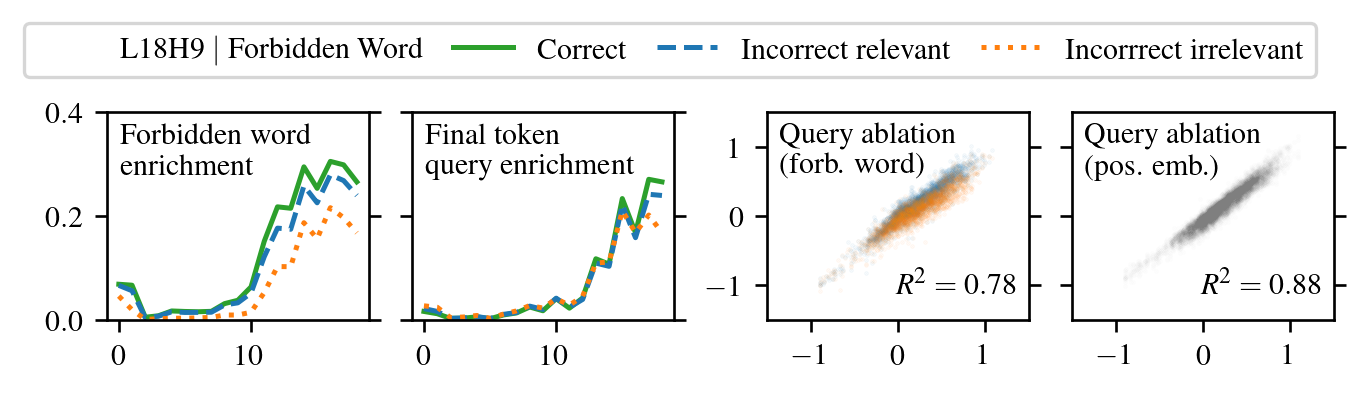

In [13]:
for head_idx, (layer, head) in enumerate(important_head_list[:1]):
    fig, _ = plt.subplots(1, 4)
    plt.subplot(1, 4, 1)

    plt.plot([], [], label=rf"$\hspace{{-0.7cm}}$L{layer}H{head} $\vert$ Forbidden Word", alpha=0)
    # Reset color cycle
    plt.gca().set_prop_cycle(None)

    colors = ["tab:green", "tab:blue", "tab:orange"]

    for i, label in enumerate(
        ["Correct", "Incorrect relevant", "Incorrrect irrelevant"]
    ):
        plt.plot(
            fenrich_fprobs[:, i, head_idx, : layer + 1].mean(axis=0)
            / np.log(10),
            label=label,
            linestyle=["-", "--", "dotted"][i],
            color=colors[i],
        )
    fig.legend(
        bbox_to_anchor=(-0.02, 1),
        loc="lower left",
        ncol=4,
        # smaller width
        columnspacing=1,
    )
    plt.text(
        0.05,
        0.95,
        "\n".join(["Forbidden word", "enrichment"]),
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.ylim(0, 0.4)

    plt.subplot(1, 4, 2)
    for i in range(3):
        plt.plot(
            qenrich_fprobs[:, i, head_idx, : layer + 1].mean(axis=0)
            / np.log(10),
            linestyle=["-", "--", "dotted"][i],
            color=colors[i],
        )
    plt.ylim(0, 0.4)
    # Remove y axis labels
    plt.gca().set_yticklabels([])
    plt.text(
        0.05,
        0.95,
        "\n".join(["Final token", "query enrichment"]),
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.subplot(1, 4, 3)
    c = plt.scatter(
        swap_flogits[:, head_idx, 0, 0] / np.log(10),
        swap_flogits[:, head_idx, 0, 1] / np.log(10),
        s=0.1,
        alpha=0.07,
        color=colors[1],
    )
    c.set_rasterized(True)
    c = plt.scatter(
        swap_flogits[:, head_idx, 0, 0] / np.log(10),
        swap_flogits[:, head_idx, 0, 2] / np.log(10),
        s=0.1,
        alpha=0.07,
        color=colors[2],
    )
    c.set_rasterized(True)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    xs = np.concatenate(
        [swap_flogits[:, head_idx, 0, 0], swap_flogits[:, head_idx, 0, 0]]
    ) / np.log(10)
    ys = np.concatenate(
        [swap_flogits[:, head_idx, 0, 1], swap_flogits[:, head_idx, 0, 2]]
    ) / np.log(10)
    r2 = sklearn.metrics.r2_score(xs, ys)
    plt.text(
        0.95,
        0.1,
        f"$R^2={r2:.2f}$",
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.05,
        0.95,
        f"Query ablation\n(forb. word)",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.subplot(1, 4, 4)
    xs = einops.repeat(
        pswap_flogits[:, 0, head_idx, 0], "x -> x r", r=n_rolls - 1
    ).flatten() / np.log(10)
    ys = pswap_flogits[:, 0, head_idx, 1:].flatten() / np.log(10)
    # Subsample xs and ys
    idxs = np.random.choice(len(xs), size=10000, replace=False)
    c = plt.scatter(
        xs[idxs],
        ys[idxs],
        s=0.1,
        alpha=0.02,
        color="tab:grey",
    )
    c.set_rasterized(True)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.gca().set_yticklabels([])
    r2 = sklearn.metrics.r2_score(xs, ys)
    plt.text(
        0.95,
        0.1,
        f"$R^2={r2:.2f}$",
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.05,
        0.95,
        f"Query ablation\n(pos. emb.)",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    fig.set_figheight(fig.get_figheight() * 0.4)

plt.savefig("./plots/attention-analysis.pdf", backend="pgf", dpi=400, bbox_inches='tight')

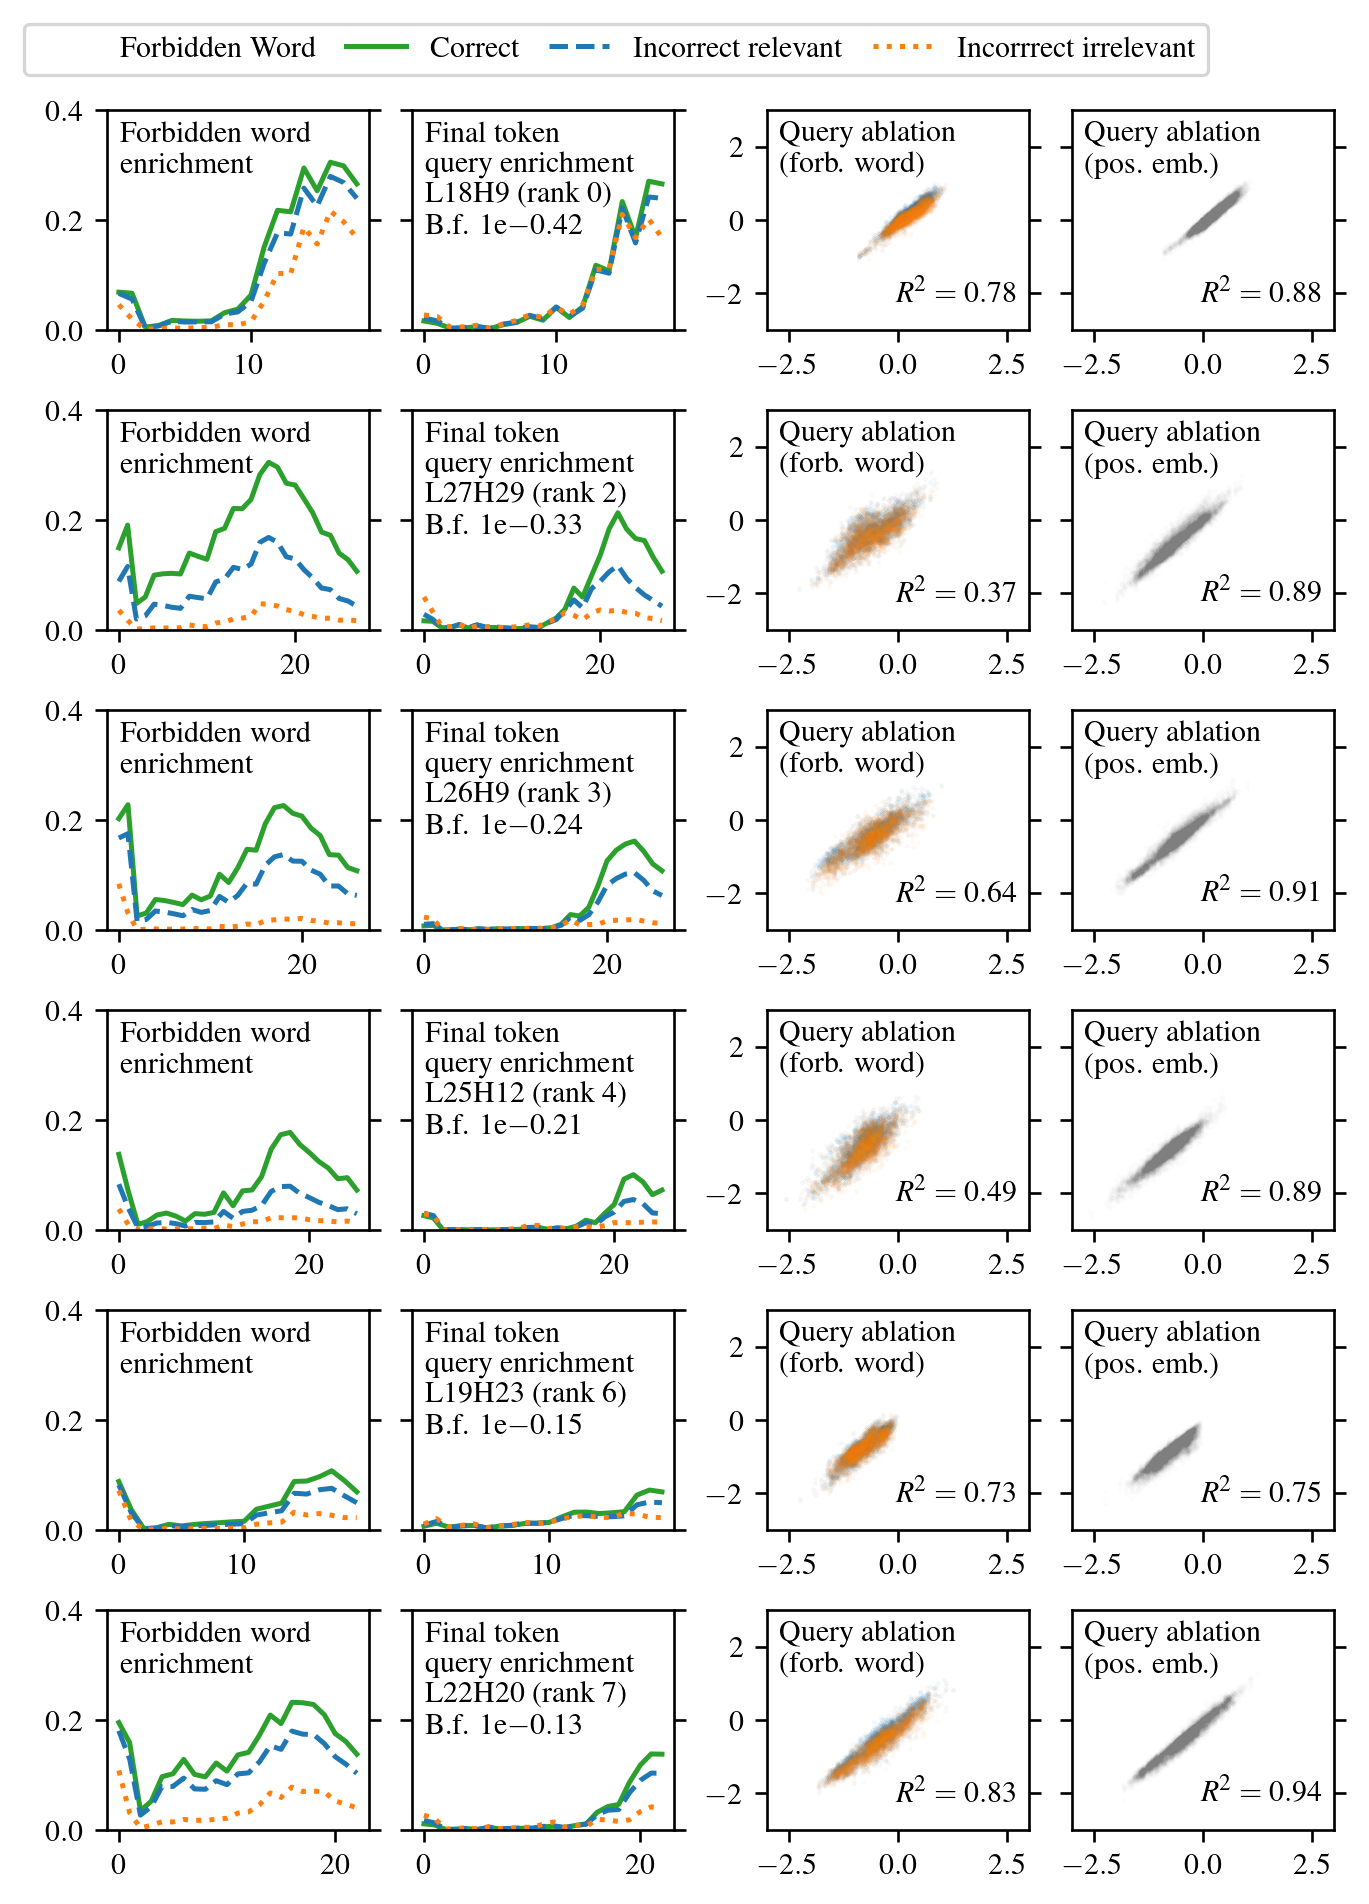

In [25]:
n_heads = 6
fig, _ = plt.subplots(n_heads, 4)
for head_idx, (layer, head) in enumerate(important_head_list[:n_heads]):
    plt.subplot(n_heads, 4, 4 * head_idx + 1)

    plt.plot([], [], label=rf"$\hspace{{-0.7cm}}$ Forbidden Word", alpha=0)
    # Reset color cycle
    plt.gca().set_prop_cycle(None)

    colors = ["tab:green", "tab:blue", "tab:orange"]

    for i, label in enumerate(
        ["Correct", "Incorrect relevant", "Incorrrect irrelevant"]
    ):
        plt.plot(
            fenrich_fprobs[:, i, head_idx, : layer + 1].mean(axis=0)
            / np.log(10),
            label=label,
            linestyle=["-", "--", "dotted"][i],
            color=colors[i],
        )
    if head_idx == 0:
        fig.legend(
            bbox_to_anchor=(-0.02, 1),
            loc="lower left",
            ncol=4,
            # smaller width
            columnspacing=1,
        )
    plt.text(
        0.05,
        0.95,
        "\n".join(["Forbidden word", "enrichment"]),
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )
    plt.ylim(0, 0.4)

    plt.subplot(n_heads, 4, 4 * head_idx + 2)
    for i in range(3):
        plt.plot(
            qenrich_fprobs[:, i, head_idx, : layer + 1].mean(axis=0)
            / np.log(10),
            linestyle=["-", "--", "dotted"][i],
            color=colors[i],
        )
    plt.ylim(0, 0.4)
    # Remove y axis labels
    plt.gca().set_yticklabels([])

    get_sgn = lambda x: "+" if x > 0 else ""
    log10_bf = log_bf_nc_c.mean(axis=0)[
        list(LABELS).index(f"L{layer}H{head}ATN")
    ] / np.log(10)
    rank = LABELS_ORDERED.tolist().index(f"L{layer}H{head}ATN")
    plt.text(
        0.05,
        0.95,
        "\n".join(
            [
                "Final token",
                "query enrichment",
                f"L{layer}H{head} (rank {rank})",
                f"B.f. 1e{get_sgn(log10_bf)}${{{log10_bf:.2f}}}$"
            ]
        ),
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.subplot(n_heads, 4, 4 * head_idx + 3)
    c = plt.scatter(
        swap_flogits[:, head_idx, 0, 0] / np.log(10),
        swap_flogits[:, head_idx, 0, 1] / np.log(10),
        s=0.1,
        alpha=0.07,
        color=colors[1],
    )
    c.set_rasterized(True)
    c = plt.scatter(
        swap_flogits[:, head_idx, 0, 0] / np.log(10),
        swap_flogits[:, head_idx, 0, 2] / np.log(10),
        s=0.1,
        alpha=0.07,
        color=colors[2],
    )
    c.set_rasterized(True)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    xs = np.concatenate(
        [swap_flogits[:, head_idx, 0, 0], swap_flogits[:, head_idx, 0, 0]]
    ) / np.log(10)
    ys = np.concatenate(
        [swap_flogits[:, head_idx, 0, 1], swap_flogits[:, head_idx, 0, 2]]
    ) / np.log(10)
    r2 = sklearn.metrics.r2_score(xs, ys)
    plt.text(
        0.95,
        0.1,
        f"$R^2={r2:.2f}$",
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.05,
        0.95,
        f"Query ablation\n(forb. word)",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.subplot(n_heads, 4, 4 * head_idx + 4)
    xs = einops.repeat(
        pswap_flogits[:, 0, head_idx, 0], "x -> x r", r=n_rolls - 1
    ).flatten() / np.log(10)
    ys = pswap_flogits[:, 0, head_idx, 1:].flatten() / np.log(10)
    # Subsample xs and ys
    idxs = np.random.choice(len(xs), size=10000, replace=False)
    c = plt.scatter(
        xs[idxs],
        ys[idxs],
        s=0.1,
        alpha=0.02,
        color="tab:grey",
    )
    c.set_rasterized(True)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.gca().set_yticklabels([])
    r2 = sklearn.metrics.r2_score(xs, ys)
    plt.text(
        0.95,
        0.1,
        f"$R^2={r2:.2f}$",
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.05,
        0.95,
        f"Query ablation\n(pos. emb.)",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

fig.set_figheight(fig.get_figheight() * 2.5)

# plt.savefig(
#     "./plots/attention-analysis-more.pdf",
#     backend="pgf",
#     dpi=400,
#     bbox_inches="tight",
# )